# Logistic Regression

Our goal is build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).
It's a bit unsettling, to be honest; however let's start!


# Import data set

In [1]:
import pandas as pd

# We'll use a dataset taken from: https://www.kaggle.com/datasets/vinicius150987/titanic3
dfSurvivals = pd.read_excel("../Fundamentals/data/titanic3.xls", index_col=None)

# Basic EDA and cleaning data

In [2]:
dfSurvivals.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [3]:
# Just use python variable replacement syntax to make the text dynamic.
from IPython.display import Markdown as md

md(f"The Titanic survivals data set consists of {dfSurvivals.shape[1]} different parameters for {dfSurvivals.shape[0]} samples.")

The Titanic survivals data set consists of 14 different parameters for 1309 samples.

Type data and memory usage

In [4]:
dfSurvivals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


Three types of data: int64, float64 and objet data. ........

Now we write down some notes about what the colums mean:

- survival: 0 = no, 1 = yes
- pclass: 1 = 1st, 2 = 2nd, 3 = 3rd
- name: self explanatory
- sex: self explanatory
- age: self explanatory
- sibsp = nr of sibilings / spouses abroad
- parch = nr of parents / children abroad
- ticket = self explanatory
- fare = passenger fare
- cabin = self explanatory
- embarked = port of embrarkation --> C = Chernourg, Q = Queenstown, S = Southhampton
- boat = lifeboad (if survived)
- body = body number (if not survive and body was recovered)
- home.dest = self explanatory
- survived = out target

The next step is searching for missing, NA and null values.

In [5]:
(dfSurvivals.isnull() | dfSurvivals.empty | dfSurvivals.isna()).sum()

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

We"ve found many missing data but in what percentage with respect the total rows?

In [6]:
def showPercentageNan(colName, dtFrame):
    perc = (dtFrame[colName].isnull().sum() / dtFrame.shape[0])
    print(f"Percent of missing '{colName}' records is {round(perc * 100,3)} %")

In [7]:
colNan = [ 
    "fare",
    "cabin",
    "embarked",
    "boat",
    "body",
    "home.dest"
]

for col in colNan:
    showPercentageNan(col, dfSurvivals)

Percent of missing 'fare' records is 0.076 %
Percent of missing 'cabin' records is 77.464 %
Percent of missing 'embarked' records is 0.153 %
Percent of missing 'boat' records is 62.872 %
Percent of missing 'body' records is 90.756 %
Percent of missing 'home.dest' records is 43.086 %


Seeing these percentials we can ignore "cabin", "boat", "body" and "home.dest" feature in our model.

In [8]:
dfSurvivals.drop(["cabin","boat","body","home.dest"], axis=1, inplace=True)

we can verify that

In [9]:
dfSurvivals.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,embarked
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,S
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,S
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,S
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,S
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,S


While on "age" feature, we can try to replace Nan with significant values

In [10]:
print(f"min age is {dfSurvivals.age.min()}")
print(f"max age is {dfSurvivals.age.max()}")

min age is 0.1667
max age is 80.0


We'll try to predict the missing value by replace this with the mean, which works well with a small dataset and is easy to implement.

In [11]:
dfSurvivals["fare"].fillna(value = dfSurvivals["fare"].mean(), inplace=True)
dfSurvivals["embarked"].fillna(dfSurvivals["embarked"].value_counts().idxmax(), inplace=True)
dfSurvivals["age"].fillna(value = dfSurvivals["age"].mean(), inplace=True)

So we can verify if there is still some missing values.

In [12]:
nrAgeNaN = dfSurvivals["age"].isna().sum()
nrFareNaN = dfSurvivals["fare"].isna().sum()
nrEmbarkedNaN = dfSurvivals["embarked"].isna().sum()
print(f"Now we have {nrAgeNaN} missing values on age column!")
print(f"Now we have {nrFareNaN} missing values on fare column!")
print(f"Now we have {nrEmbarkedNaN} missing values on embarked column!")

Now we have 0 missing values on age column!
Now we have 0 missing values on fare column!
Now we have 0 missing values on embarked column!


Before building the model, we need to perform label encoding for the categorical variables.

In [13]:
from sklearn.preprocessing import LabelEncoder

labelencoder_X = LabelEncoder()

dfSurvivals["name"] = labelencoder_X.fit_transform(dfSurvivals["name"])
dfSurvivals["embarked"] = labelencoder_X.fit_transform(dfSurvivals["embarked"])
dfSurvivals["ticket"] = dfSurvivals["ticket"].astype(str)
dfSurvivals["ticket"] = labelencoder_X.fit_transform(dfSurvivals["ticket"])


As concerns sex categories, we'll use OneHotEncoder because the gender of the passenger is with the same importancy; so we'll split sex into two new feature and each column will contains encoded values.

In [14]:
from sklearn.preprocessing import OneHotEncoder

result = OneHotEncoder().fit_transform(dfSurvivals["sex"].values.reshape(-1, 1)).toarray()
dfSurvivals[["Female", "Male"]] = pd.DataFrame(result, index = dfSurvivals.index)
dfSurvivals.drop(["sex"], axis=1, inplace=True)

And that is the result

In [15]:
dfSurvivals.head()

,pclass,survived,name,age,sibsp,parch,ticket,fare,embarked,Female,Male
0,1,1,21,29.0000,0,0,187,211.3375,2,1.0,0.0
1,1,1,23,0.9167,1,2,49,151.5500,2,0.0,1.0
2,1,0,24,2.0000,1,2,49,151.5500,2,1.0,0.0
3,1,0,25,30.0000,1,2,49,151.5500,2,0.0,1.0
4,1,0,26,25.0000,1,2,49,151.5500,2,1.0,0.0


# Train and test the model with mean

Split data in train and test parts.

In [16]:
dfSurvivalPred = dfSurvivals.copy()

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 

X = dfSurvivals.drop("survived", axis=1)
y = dfSurvivals["survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

model = LogisticRegression(max_iter=5000)
model.fit(X_train,y_train)
p_predict = model.predict(X_test)

print("The accuracy is", round(accuracy_score(p_predict, y_test) * 100,2))

The accuracy is 81.17


# Model Performance Analysis

We'll use two measures:
1. Confusion Matrix
2. Classification Report with Precision, Recall and F1-Score.

The confusion matrix is a table that is used to show the number of correct and incorrect predictions on a classification problem when the real values of the Test Set are known. It is of the format

|    |    |
|----|----|
| TP | FP |
| FN | TN |

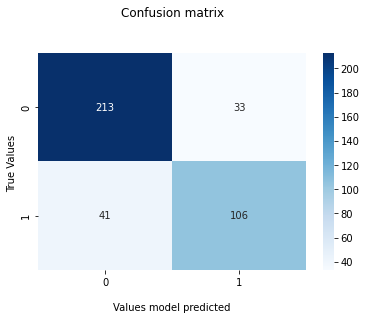

Classification Report
              precision    recall  f1-score   support

           0       0.84      0.87      0.85       246
           1       0.76      0.72      0.74       147

    accuracy                           0.81       393
   macro avg       0.80      0.79      0.80       393
weighted avg       0.81      0.81      0.81       393



In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

confusionMatrix = pd.crosstab(y_test, p_predict)
classificationReport = classification_report(y_test, p_predict)


fx = sns.heatmap(confusionMatrix, annot=True, cmap="Blues", fmt="d")
fx.set_title("Confusion matrix\n\n");
fx.set_xlabel("\nValues model predicted")
fx.set_ylabel("True Values ")
plt.show()
print(f"Classification Report\n{classificationReport}")

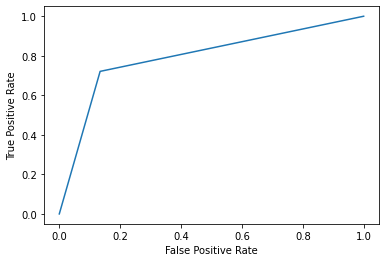

In [19]:
from sklearn import metrics

y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, p_predict)

plt.plot(fpr,tpr)
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()